**Tutorial 7 - Photometric redshifts.**

In this tutorial we will try to builds models to predict galaxy redshifts from their photometry in 5 bands.

We will get some practice with the scikit-learn package which contains powerful tools for simple machine learning problems. (https://scikit-learn.org/stable/user_guide.html)

1) Import the data from the file reduced_galaxy_data.fits.  This file contains a small subset of data from the Slone Digital Sky Survey.  The columns in the fits table are: id number, the measured spectroscopic redshift, the fluxes in five bands (ugriz), and the magnitudes in the same five bands.  Note that the entry in the flux and magnitude columns is an array of 5 entries.

Put the redshifts into an array called `redshift` and the magnitudes into am two dimensional array `color_block` where `color_block[0]` are the 5 magnitudes for the first entry.

Make a scatter plot of redshift versus u band magnitude.

ColDefs(
    name = 'OBJID'; format = '22A'
    name = 'Z'; format = 'E'
    name = 'MAGNITUDES'; format = '5E'; dim = '(5)'
    name = 'FLUXES'; format = '5E'; dim = '(5)'
)


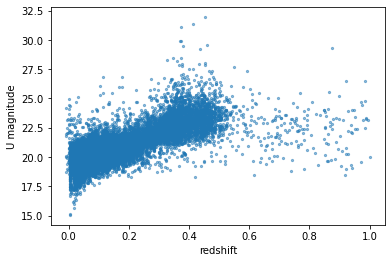

In [174]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#import pandas as pa

filename = "./reduced_galaxy_data.fits"
hdul = fits.open(filename)
print(hdul[1].columns)
data = hdul[1].data

redshift = np.array(data['z'])
color_block=np.array(data['MAGNITUDES'])


plt.scatter(redshift,color_block[:,0],s=5, alpha=0.5)
plt.xlabel('redshift')
plt.ylabel('U magnitude')
plt.show()


2) Subtract the U band magnitude from all the other bands so that we have 4 colors and one apparent magnitude.

In [175]:
for i in np.arange(1,5) :
    color_block[:,i] = color_block[:,i] - color_block[:,0]

3) From sklearn import `linear_model`.  Make a `linear_model.LinearRegression(copy_X=True)` object 
and then fit a model that predicts redshifts from the colors. (see https://scikit-learn.org/stable/modules/linear_model.html for more information.)  Print out the coefficients.  Use the model.score() function to give the score for the model which in this case is the R^2 statistic (coefficient of determination).

In [176]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
lin=linear_model.LinearRegression(copy_X=True)
#X_test,X_train,y_test, y_train=train_test_split(color_block[:,1:5], redshift,test_size=0.2, train_size=0.7,random_state=42)

#prepare fitting space
space = np.linspace(np.min(color_block), np.max(color_block),num=len(color_block))

#color_name=['g-u','r-u','i-u','z-u']
pre=lin.fit(color_block, redshift)
y_pre=lin.predict(color_block)

print('the score of the model:', lin.score(color_block, redshift))
print('coefficients:',lin.coef_)

the score of the model: 0.6903514773206605
coefficients: [ 0.05516343  0.16267088 -0.02181361 -0.08249151  0.0119597 ]


4) Use the model to predict the redshifts for all of the galaxies.  Make a scatter plot of the predicted vs observed redshifts. Decreasing the alpha parameter can make this clearer.

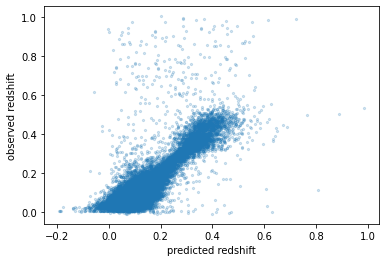

In [177]:
# predict redshifts
all_pre=lin.predict(color_block)
# plot prediction vs redshifts
plt.scatter(all_pre,redshift, alpha=0.2, s=5)
plt.xlabel('predicted redshift')
plt.ylabel('observed redshift')
plt.show()

5) Scatter plots can be deceiving.  The density of points can be estimated with a Gaussian kernel.  This should do that.  Put some labels on the plot and overlay a contour plot.  (If you can make a nicer countour plot than this extra point.)

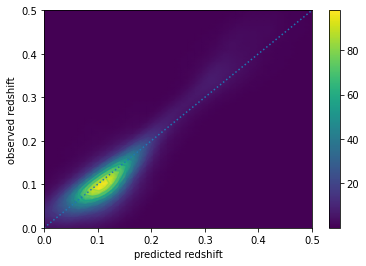

In [178]:
from scipy.stats import kde

nbins = 40
#k = kde.gaussian_kde(np.array([predictions,observations]))
k = kde.gaussian_kde(np.array([all_pre,redshift]))

xi, yi = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi,yi, zi.reshape(xi.shape), shading='gouraud')
plt.plot([0,0.5],[0,0.5],linestyle=':')
plt.colorbar()

plt.contour(xi, yi, zi.reshape(xi.shape) )

plt.xlabel('predicted redshift')
plt.ylabel('observed redshift')

plt.show()

In [179]:
residuals=all_pre-redshift
residuals[np.where((zi>=85)&(zi<=95))]

array([ 0.028886  , -0.59079967,  0.02462423,  0.01936295,  0.01408246])

6) We are going to need a quick way of assessing how well a model is working.

Make a function that takes the residuals (predictions - true values) and prints six things : 1) their median, 2) mean, 3) the range the contains 90% of the cases with 5% larger and smaller, 4) the same for 80%, 5) the standard deviation and 6) the mean absolute deviation.  

Call this function `report()`.

In [180]:
def report(pre_dat,true_dat, frac) :
    if frac==True:
        residuals=(pre_dat-true_dat)/true_dat
    else:
        residuals=pre_dat-true_dat
    mae=np.sum(abs(residuals-np.mean(residuals)))/len(residuals)
    #zi = k(np.vstack([pre_dat.flatten(), true_dat.flatten()]))
    qu=np.quantile(residuals,[0.05, 0.10, 0.90, 0.95])
    dat=np.array([np.median(residuals), np.mean(residuals),\
                  [qu[0], qu[3]],[qu[1], qu[2]],np.std(residuals),mae])
    print('median:',dat[0])
    print('mean:', dat[1])
    print('90\% range:', dat[2])
    print('80\% range:', dat[3])
    print('standard deviation:', dat[4])
    print('MAE:', dat[5])
    return (dat)
print(report(all_pre, redshift, frac=False))

median: 0.002784037181571053
mean: -1.119712638695372e-16
90\% range: [-0.06792404618830368, 0.06937015494438363]
80\% range: [-0.045399798346147116, 0.05046183893802484]
standard deviation: 0.05893893543241415
MAE: 0.033555519981132535
[0.002784037181571053 -1.119712638695372e-16
 list([-0.06792404618830368, 0.06937015494438363])
 list([-0.045399798346147116, 0.05046183893802484]) 0.05893893543241415
 0.033555519981132535]


<ipython-input-180-0c0458959782>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dat=np.array([np.median(residuals), np.mean(residuals),\


7) We need a quick way of calculating the residuals, but we cannot calculate the residuals on the same data as we fit the model.  Let's make a function the splits the data in two, fits on one subset and calculates the residuals on the remaining subset.

The function should take the independent variables `X`, the dependent variable `Y`, the model `model` and the fraction of the data set that will be used for fitting the the model.  The `model` has the functions `fit()` and `predict()` as for the sklearn models.  The function should split the data set into two random subsets: fit and test.  It should then fit the model and then return the residuals for the test set and the true Y values of the test set.

In [181]:
def test_residuals(X,Y,model,fit_fraction) :
    N=len(Y)
    # make an index
    index=np.arange(N)
    # shuffle the index
    np.random.shuffle(index)

    #split the index into two parts 
    split = int(fit_fraction*N)
    index_fit = index[0:split]
    index_test = index[split:-1]

    # define X_fit,Y_fit
    X_fit = X[index_fit]
    Y_fit = Y[index_fit]
    
    # define X_test, Y_test
    X_test = X[index_test]
    Y_test = Y[index_test]
    
 
    ## fit model
    model.fit(X_fit, Y_fit)
   
    ## predict redshifts
    predict=model.predict(X_test)
    
    resi=predict-Y_test
   
    return resi, Y_test, predict

8) Use your function `test_residuals()` to get a set of residuals with `linear_mod` and our data.  Use 80% of the data for fitting and 20% for testing. Run `report()` on the resulting residuals to see how well this model predicts the redshifts.

In [182]:
RESI_t=test_residuals(color_block, redshift, linear_model.LinearRegression(copy_X=True), 0.8)[0]
y_tes=test_residuals(color_block, redshift, linear_model.LinearRegression(copy_X=True), 0.8)[1]
y_pre=test_residuals(color_block, redshift, linear_model.LinearRegression(copy_X=True), 0.8)[2]
report(y_pre, y_tes, frac=False)[5]

median: 0.01007644246521644
mean: 0.0018430636745196474
90\% range: [-0.25064445331043417, 0.2179926724394007]
80\% range: [-0.14987282994098855, 0.14241844928745404]
standard deviation: 0.13506305828660492
MAE: 0.0930204348489958


<ipython-input-180-0c0458959782>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dat=np.array([np.median(residuals), np.mean(residuals),\


0.0930204348489958

9) Make a nice histogram of the residuals.

Text(0, 0.5, 'counts')

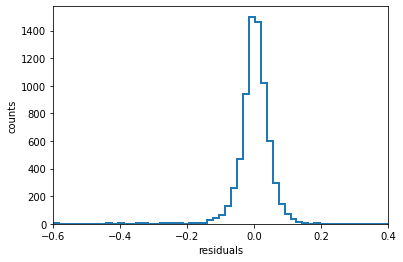

In [183]:
plt.hist(RESI_t, bins=int(np.sqrt(len(RESI_t))), histtype='step', linewidth=2)
plt.xlim(-0.6,0.4)
plt.xlabel('residuals')
plt.ylabel('counts')

10) What is important is that the fractional error in the redshift is small, i.e. `residuals / y`.  Find the fractional residuals, run them through `report` and make a histogram of them.

<ipython-input-180-0c0458959782>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dat=np.array([np.median(residuals), np.mean(residuals),\


median: 0.09687604833913652
mean: -0.326284970948064
90\% range: [-0.8216704686957517, 3.674000882286938]
80\% range: [-0.6966974165478363, 2.294944161879126]
standard deviation: 174.33376296146878
MAE: 4.188742236521402


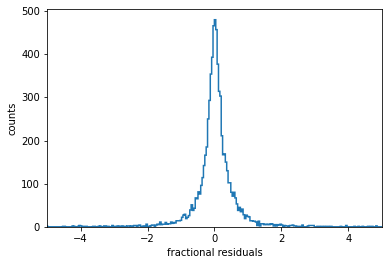

4.188742236521402


In [184]:
frac_resi_par=report(y_pre, y_tes, frac=True)
plt.hist(RESI_t/y_tes, bins='auto', histtype='step', linewidth=1.5)
#plt.vlines(min(frac_resi_par[2]), 0, 1500, linestyles='--')
#plt.vlines(max(frac_resi_par[2]), 0, 1500, linestyles='--')
plt.xlim(-5,5)
plt.xlabel('fractional residuals')
plt.ylabel('counts')
plt.show()
print(frac_resi_par[5])

11) Would you consider this a successful model in terms of the fractional residuals?

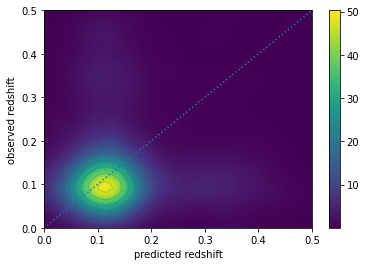

I don't think so, because the standard deviation is very high and the contour plot shows that the data is 
 scattering but which is expected to be more linear


In [185]:
from scipy.stats import kde

nbins = 40
#k = kde.gaussian_kde(np.array([predictions,observations]))
k = kde.gaussian_kde(np.array([y_pre,y_tes]))

xi, yi = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi,yi, zi.reshape(xi.shape), shading='gouraud')
plt.plot([0,0.5],[0,0.5],linestyle=':')
plt.colorbar()

plt.contour(xi, yi, zi.reshape(xi.shape) )

plt.xlabel('predicted redshift')
plt.ylabel('observed redshift')

plt.show()
print("I don't think so, because the standard deviation is very high and the contour plot shows that the data is \n scattering but which is expected to be more linear")

12) So far, the model has been linear in the parameters AND the colors/magnitude.  It might improve the model if we include terms in the model that are second order in the colors while keeping it linear in the parameters.

sklearn provides a convenient function that will transform our matrix of colors into a larger matrix that includes higher order terms.  In particular, `PolynomialFeatures(2).fit_transform(color_block)` will include all the colors squared and all the products of the colors.

Use this function to transform our `color_block` into another one with second order terms.

How many more parameters will be in a linear model fit with this new data matrix?

In [186]:
from sklearn.preprocessing import PolynomialFeatures

color_block2 = PolynomialFeatures(2).fit_transform(color_block)
lin=linear_model.LinearRegression()

prer=lin.fit(color_block2, redshift)
y_prer=lin.predict(color_block2)

print('coefficients:',lin.coef_)
print(len(lin.coef_))

coefficients: [ 0.         -0.29940223  0.74432886 -1.08102713 -0.78583631  1.03383831
  0.00891839 -0.02674147  0.04724677  0.03295768 -0.04347766 -0.03126395
  0.07604617 -0.048743   -0.00246956 -0.00384667 -0.01279939 -0.02004219
  0.03297833  0.0201338  -0.00765766]
21


13) Create and fit a new linear model using this new data matrix.

What is the score for this model?

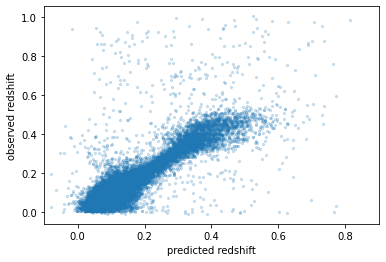

the score of the model: 0.7438913853976372


In [187]:
all_pre_2=lin.predict(color_block2)
# plot prediction vs redshifts
plt.scatter(all_pre_2,redshift, alpha=0.2, s=5)

plt.xlim(-0.1,0.9)
plt.xlabel('predicted redshift')
plt.ylabel('observed redshift')
plt.show()

print('the score of the model:', lin.score(color_block2, redshift))

14) Use your functions `test_residuals()` and `report()` with this new model as before.  Make a histogram of the residuals as before.

median: 0.07722810665201647
mean: 0.9451499890980241
90\% range: [-0.7511478588183084, 3.668600470343535]
80\% range: [-0.6406636657628284, 2.3131598078457416]
standard deviation: 26.685168088792658
MAE: 1.77925932775821


<ipython-input-180-0c0458959782>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dat=np.array([np.median(residuals), np.mean(residuals),\


1.77925932775821

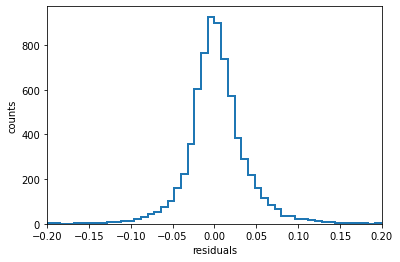

In [188]:
RS=test_residuals(color_block2, redshift, lin, 0.8)[0]
Y_t=test_residuals(color_block2, redshift, lin, 0.8)[1]
Y_p=test_residuals(color_block2, redshift, lin, 0.8)[2]
plt.hist(RS, bins=50, histtype='step', linewidth=2, range=(-0.2,0.2))
plt.xlim(-0.2,0.2)
plt.xlabel('residuals')
plt.ylabel('counts')

report(Y_p,Y_t, frac=True)[5]

15) As before, do the same for the fractional residuals.

median: 0.07722810665201647
mean: 0.9451499890980241
90\% range: [-0.7511478588183084, 3.668600470343535]
80\% range: [-0.6406636657628284, 2.3131598078457416]
standard deviation: 26.685168088792658
MAE: 1.77925932775821


<ipython-input-180-0c0458959782>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dat=np.array([np.median(residuals), np.mean(residuals),\


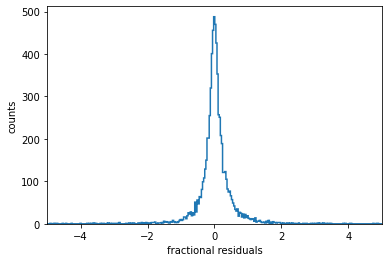

[0.07722810665201647 0.9451499890980241
 list([-0.7511478588183084, 3.668600470343535])
 list([-0.6406636657628284, 2.3131598078457416]) 26.685168088792658
 1.77925932775821]


In [189]:
frac_resi_par=report(Y_p, Y_t, frac=True)
plt.hist(RS/Y_t, bins='auto', histtype='step', linewidth=1.5)
#plt.vlines(min(frac_resi_par[2]), 0, 1500, linestyles='--')
#plt.vlines(max(frac_resi_par[2]), 0, 1500, linestyles='--')
plt.xlim(-5,5)
plt.xlabel('fractional residuals')
plt.ylabel('counts')
plt.show()
print(frac_resi_par)

16) Make a new contour plot for predictions based on `color_block2`.

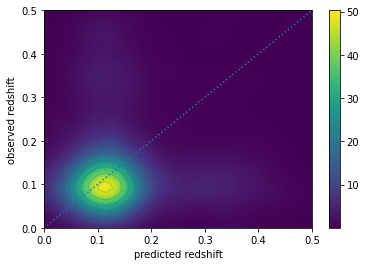

In [190]:
nbins = 40
#k = kde.gaussian_kde(np.array([predictions,observations]))
k2 = kde.gaussian_kde(np.array([Y_p, Y_t]))

xi2, yi2 = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi2 = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape), shading='gouraud')
plt.plot([0,0.5],[0,0.5],linestyle=':')
plt.colorbar()

plt.contour(xi2, yi2, zi2.reshape(xi2.shape) )

plt.xlabel('predicted redshift')
plt.ylabel('observed redshift')

plt.show()
#print("I don't think so")

17) Uses `sklearn.model_selection.cross_val_score` to find an estimate of the mean absolute error using k-fold validation. (scoring="neg_mean_absolute_error", cv=5)

In [191]:
from sklearn.model_selection import cross_val_score
score_1=cross_val_score(lin, color_block, redshift, scoring="neg_mean_absolute_error", cv=5)
score_2=cross_val_score(lin, color_block2, redshift, scoring="neg_mean_absolute_error", cv=5)
print("score of the first model:", np.mean(score_1))
print("score of the second model:",np.mean(score_2))

score of the first model: -0.033776666255568244
score of the second model: -0.02863700310339602


18) Is this model an improvement on the first one?

In [192]:
print('from mean absolute error and the score of cross-validation analysis, the sceond is a bit better')

from mean absolute error and the score of cross-validation analysis, the sceond is a bit better
